# Object Detection with Cofar-10 Dataset Using ResNet50 Model

In [10]:
#!pip install py7zr

## dependencies

In [43]:
from zipfile import ZipFile
import py7zr
import os
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import tensorflow as tf

## dataset

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle competitions download -c cifar-10

 93% 668M/715M [00:06<00:00, 61.1MB/s]
100% 715M/715M [00:06<00:00, 109MB/s] 


In [3]:
!ls


cifar-10.zip  kaggle.json  sample_data


In [8]:
# unzipping the dataset
dataset = "/content/cifar-10.zip"

with ZipFile(dataset, "r") as zip:
  zip.extractall()
  print("succesfully extracted the dataset")

succesfully extracted the dataset


In [12]:
train_archive = py7zr.SevenZipFile("/content/train.7z", mode="r")
train_archive.extractall()
train_archive.close()

In [13]:
!ls

cifar-10.zip  sample_data	    test.7z  train.7z
kaggle.json   sampleSubmission.csv  train    trainLabels.csv


## data exploration and preprocessing

In [15]:
file_names = os.listdir("/content/train")
len(file_names)

50000

In [16]:
print(file_names[:5])
print(file_names[-5:])

['31192.png', '21378.png', '29671.png', '25882.png', '38344.png']
['29878.png', '39424.png', '44391.png', '46053.png', '23911.png']


In [17]:
# labels processing
labels_df = pd.read_csv("/content/trainLabels.csv")
labels_df.shape

(50000, 2)

In [18]:
labels_df.head(10)

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile
5,6,automobile
6,7,bird
7,8,horse
8,9,ship
9,10,cat


In [26]:
print(
    labels_df[labels_df["id"] == 29671]
)


          id label
29670  29671  deer


In [33]:
len(labels_df["label"].value_counts())

10

In [28]:
labels_df.tail(10)

,id,label
49990,49991,deer
49991,49992,bird
49992,49993,airplane
49993,49994,automobile
49994,49995,airplane
49995,49996,bird
49996,49997,frog
49997,49998,truck
49998,49999,automobile
49999,50000,automobile


In [34]:
# encoding labels manually
labels_dict = {
    "airplane": 0,
    "automobile": 1,
    "bird": 2,
    "cat": 3,
    "deer": 4,
    "dog": 5,
    "frog": 6,
    "horse": 7,
    "ship": 8,
    "truck": 9,
}

In [37]:
labels_df

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile
...,...,...
49995,49996,bird
49996,49997,frog
49997,49998,truck
49998,49999,automobile


In [38]:
# mapping
labels = [labels_dict[i] for i in labels_df["label"]]

In [41]:
print(labels_df[:5])
print("-"*50)
print(labels_df[-5:])

   id       label
0   1        frog
1   2       truck
2   3       truck
3   4        deer
4   5  automobile
--------------------------------------------------
          id       label
49995  49996        bird
49996  49997        frog
49997  49998       truck
49998  49999  automobile
49999  50000  automobile


In [39]:
print(labels[:5])
print(labels[-5:])

[6, 9, 9, 4, 1]
[2, 6, 9, 1, 1]


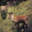

In [44]:
# visualizing sample images
img = cv2.imread("/content/train/29671.png")
cv2_imshow(img)

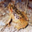

In [45]:
img = cv2.imread("/content/train/7796.png")
cv2_imshow(img)

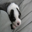

In [46]:
img = cv2.imread("/content/train/45888.png")
cv2_imshow(img)

In [47]:
labels_df[labels_df["id"] == 45888]

,id,label
45887,45888,dog


In [48]:
labels_df.head()

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


In [49]:
id_list = list(labels_df["id"])

print(id_list[:5])
print(id_list[-5:])

[1, 2, 3, 4, 5]
[49996, 49997, 49998, 49999, 50000]


In [50]:
# converting images to numpy arrays
train_folder = "/content/train/"
data = []

for id in id_list:
  image = Image.open(train_folder + str(id) + ".png")
  image = np.array(image)
  data.append(image)

In [53]:
type(data[0])

numpy.ndarray

In [52]:
len(data)

50000

In [54]:
data[0].shape

(32, 32, 3)

In [56]:
# converting the image list and label list to np arrays
X, y = np.array(data), np.array(labels)

In [58]:
print(type(X))
print(type(y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [60]:
print(X.shape)
print(y.shape)

(50000, 32, 32, 3)
(50000,)


In [61]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 21
)
print(X.shape)
print(X_train.shape)
print(X_test.shape)

(50000, 32, 32, 3)
(40000, 32, 32, 3)
(10000, 32, 32, 3)


In [62]:
# normalizing the data (scaling)
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

## modelling, training and evaluation